In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipynbname
import os
import json
import unicodedata, re

# 1. Import original dataframe and update data

The initial data collection was done in November 2024; it included data from different sources:

- Register of Buildings and Dwellings (https://www.housing-stat.ch/it/madd/public.html#scaricare_i_dati) --> has data of building properties and heating technology
- Electricity production plants (https://www.geocat.ch/geonetwork/srv/ita/catalog.search#/metadata/e5a00bdb-5022-4856-ad4a-d1afe7bf38b0) --> has the data related to all production plants actually installed in Switzerland
- Suitability of roofs for the use of solar energy (https://www.geocat.ch/geonetwork/srv/eng/catalog.search#/metadata/b614de5c-2f12-4355-b2c9-7aef2c363ad6)
- Cadastral data (https://www.geocat.ch/geonetwork/srv/eng/catalog.search#/metadata/a3c0f7fb-1be0-4385-9c54-33b65ae3e1ae) --> has the shapefiles of each infrastructure in Switzerland. These data is not available for all the Cantons.

The output of the first data collection is one unique dataframe that contains for each residential building in Switzerland the data related to its properties, heating technology, PV plant presence and shape (for the Cantons with open cadastral data available).
In order to have more updated data, the original geodataframe (here named 'gdf_input') is updated with data from the first two databases (while the data on solar potential didn't change over the last year).

In [2]:
notebook_path = ipynbname.path()
notebook_dir = os.path.dirname(notebook_path)

gdf_file = '/data/gdf_input.gpkg'

gdf_raw = gpd.read_file(notebook_dir + gdf_file)
gdf = gdf_raw.to_crs(epsg=2056)

In [3]:
print(gdf.columns)

Index(['EGID', 'OBJID', 'R1_OBJID', 'R1_EGRIS_E', 'GDEKT', 'GGDENAME', 'GKODE',
       'GKODN', 'GSTAT', 'GKAT', 'GKLAS', 'GBAUJ', 'GBAUP', 'GAREA', 'GASTW',
       'GANZWHG', 'GEBF', 'GWAERZH1', 'GENH1', 'GWAERSCEH1', 'GWAERDATH1',
       'GWAERZW1', 'GENW1', 'GWAERSCEW1', 'FLAECHE', 'STROMERTRAG',
       'STROMERTRAG_SOMMERHALBJAHR', 'STROMERTRAG_WINTERHALBJAHR',
       'BeginningOfOperation', 'TotalPower', 'geometry'],
      dtype='object')


In [4]:
gdf = gdf.drop(columns=['GDEKT', 'GGDENAME', 'GKODE', 'GKODN', 'GSTAT', 'GKAT', 'GKLAS', 'GBAUJ', 'GBAUP', 'GAREA', 'GASTW', 'GANZWHG', 'GEBF', 'GWAERZH1', 'GENH1', 'GWAERSCEH1', 'GWAERDATH1', 'GWAERZW1', 'GENW1', 'GWAERSCEW1', 'BeginningOfOperation', 'TotalPower'])
gdf['EGID'] = gdf['EGID'].astype(int)

In [5]:
RBD_file = '/data/gebaeude_batiment_edificio.csv'

df_RBD = pd.read_csv(notebook_dir + RBD_file, sep='\t', low_memory=False)
df_RBD = df_RBD.drop(columns=['GGDENR', 'EGRID', 'LGBKR', 'LPARZ', 'LPARZSX', 'LTYP', 'GEBNR', 'GBEZ', 'GKSCE', 'GBAUM', 'GABBJ', 'GVOL', 'GVOLNORM', 'GVOLSCE', 'GAZZI', 'GSCHUTZR', 'GWAERSCEH2', 'GWAERDATH2', 'GWAERDATW1', 'GWAERZW2', 'GENW2', 'GWAERSCEW2', 'GWAERDATW2', 'GEXPDAT'])

In [6]:
gdf_merge = gdf.merge(df_RBD, how='left', on='EGID')

In [7]:
plants_file = '/data/ch.bfe.elektrizitaetsproduktionsanlagen.gpkg'

gdf_PV = gpd.read_file(notebook_dir + plants_file, layer='ElectricityProductionPlant')
gdf_PV = gdf_PV.to_crs(epsg=2056)

gdf_PV = gdf_PV.loc[gdf_PV['SubCategory'] == 'subcat_2']
gdf_PV = gdf_PV.drop(columns=['Address', 'PostCode', 'Municipality', 'Canton', 'InitialPower', 'MainCategory', 'SubCategory', 'PlantCategory'])

In [8]:
cantons_with_cadastral_data = ['GR', 'BE','VS', 'TI', 'SG', 'ZH', 'FR', 'AG', 'UR', 'TG', 'SZ', 'SO', 'GL', 'BL', 'GE', 'SH', 'ZG', 'AI', 'BS']

In [9]:
gdf_merge_cad = gdf_merge[gdf_merge['GDEKT'].isin(cantons_with_cadastral_data)].copy()
gdf_merge_PV_1 = gpd.sjoin(gdf_merge_cad, gdf_PV, how="left", predicate='intersects')

In [10]:
gdf_merge_PV_1 = gdf_merge_PV_1.drop_duplicates(subset='EGID')
gdf_merge_PV_1 = gdf_merge_PV_1.drop(columns=['index_right'])

In [11]:
print(len(gdf_merge_cad), '----> Buildings in the initial data')
print(len(gdf_PV), '----> PV plants')
print(len(gdf_merge_PV_1), '----> Buildings in the resulting joined gdf')

gdf_merge_PV_1['TotalPower'] = gdf_merge_PV_1['TotalPower'].fillna(0)
gdf_merge_PV_1['Is_First'] = gdf_merge_PV_1.groupby('xtf_id').cumcount() == 0
gdf_merge_PV_1.loc[~gdf_merge_PV_1['Is_First'], 'TotalPower'] = 0
gdf_merge_PV_1 = gdf_merge_PV_1.drop(columns=['Is_First'])

print(len(gdf_merge_PV_1.loc[~gdf_merge_PV_1['TotalPower'].isin([0])]), '----> Number of buildings with PV after filtering for PV assigned to different buildings')

1433255 ----> Buildings in the initial data
306144 ----> PV plants
1433255 ----> Buildings in the resulting joined gdf
183584 ----> Number of buildings with PV after filtering for PV assigned to different buildings


In [12]:
gdf_merge_cad_no = gdf_merge[~gdf_merge['GDEKT'].isin(cantons_with_cadastral_data)].copy()

In [13]:
gdf_bld_PV_10 = gpd.sjoin_nearest(gdf_merge_cad_no, gdf_PV, how='left', distance_col='distance', max_distance=10)
gdf_bld_PV_10 = gdf_bld_PV_10.drop(columns=['index_right', 'distance'])
print(len(gdf_merge_cad_no), '----> Number of initial buildings')
print(len(gdf_bld_PV_10), '----> Number of buildings after merging with PV data')
print(len(gdf_bld_PV_10.loc[~gdf_bld_PV_10['TotalPower'].isna()]), '----> Number buildings with PV')

gdf_bld_PV_10['TotalPower'] = gdf_bld_PV_10['TotalPower'].fillna(0)
gdf_bld_PV_10 = gdf_bld_PV_10.drop_duplicates(subset='EGID')
print(len(gdf_bld_PV_10), '----> Number of buildings after eliminating EGID duplicates')

gdf_bld_PV_10['Is_First'] = gdf_bld_PV_10.groupby('xtf_id').cumcount() == 0
gdf_bld_PV_10.loc[~gdf_bld_PV_10['Is_First'], 'TotalPower'] = 0
gdf_bld_PV_10 = gdf_bld_PV_10.drop(columns=['Is_First'])

print(len(gdf_bld_PV_10.loc[~gdf_bld_PV_10['TotalPower'].isin([0])]), '----> Number of buildings with PV after filtering for PV assigned to different buildings')
print(len(gdf_merge_cad_no) - len(gdf_bld_PV_10), '----> Number of buildings missing')
print( len(gdf_bld_PV_10.loc[~gdf_bld_PV_10['TotalPower'].isin([0])]) / len(gdf_bld_PV_10) * 100, '----> % of buildings with PV')

285080 ----> Number of initial buildings
287792 ----> Number of buildings after merging with PV data
60587 ----> Number buildings with PV
285080 ----> Number of buildings after eliminating EGID duplicates
53138 ----> Number of buildings with PV after filtering for PV assigned to different buildings
0 ----> Number of buildings missing
18.639680089799356 ----> % of buildings with PV


In [14]:
gdf_final = pd.concat([gdf_merge_PV_1, gdf_bld_PV_10])

# 2. Filter for needed information

In [15]:
gdf = gdf_final.copy()

In [16]:
gdf[['GKLAS', 'GBAUP', 'GWAERZH1', 'GWAERZH2', 'GWAERZW1', 'GENH1', 'GENH2', 'GENW1']] = gdf[['GKLAS', 'GBAUP', 'GWAERZH1', 'GWAERZH2', 'GWAERZW1', 'GENH1', 'GENH2', 'GENW1']].fillna(0)

The meaning of the columns names can be found in 'kodes_codes_codici.csv' or here: https://www.housing-stat.ch/catalog/it/4.2/final

In [17]:
gdf["Type"] = gdf["GKLAS"].map({1110: "SFH", 1121: "DFH", 1122: "MFH"}).fillna("No Info")
gdf["Construction Period"] = pd.cut(gdf["GBAUP"], bins=[-float("inf"), 8011, 8012, 8013, 8014, 8015, 8017, 8019, 8021, float("inf")],
                                    labels=["< 1920", "1921-1945", "1946-1960", "1961-1970", "1971-1980", "1981-1990", "1991-2000", "2001-2010", "> 2010"])
gdf["Gen_SH"] = pd.cut(gdf["GWAERZH1"], bins=[-float("inf"), 1, 7400, 7411, 7421, 7435, 7436, 7441, 7452, 7461, float("inf")],
                       labels=["", "No_Heating", "HP", "ST", "Boiler", "Heater", "Cogeneration", "EH", "DH", "Indeterminate"])
gdf["Gen_SH2"] = pd.cut(gdf["GWAERZH2"], bins=[-float("inf"), 1, 7400, 7411, 7421, 7435, 7436, 7441, 7452, 7461, float("inf")],
                       labels=["", "No_Heating", "HP", "ST", "Boiler", "Heater", "Cogeneration", "EH", "DH", "Indeterminate"])
gdf["Gen_DHW"] = pd.cut(gdf["GWAERZW1"], bins=[-float("inf"), 1, 7600, 7610, 7620, 7634, 7640, 7651, float("inf")],
                        labels=["", "No_Heating", "HP", "ST", "Boiler", "Cogeneration", "EH", "Indeterminate"])
gdf["Energy_SH"] = pd.cut(gdf["GENH1"], bins=[-float("inf"), 1, 7500, 7501, 7512, 7513, 7520, 7530, 7543, 7560, 7570, 7582, float("inf")],
                          labels=["", "No_Heating", "Aria", "Geothermic", "Water", "Gas_Boiler", "Oil_Boiler", "Wood_Boiler", "EH", "ST", "DH", "Indeterminate"])
gdf["Energy_SH2"] = pd.cut(gdf["GENH2"], bins=[-float("inf"), 1, 7500, 7501, 7512, 7513, 7520, 7530, 7543, 7560, 7570, 7582, float("inf")],
                          labels=["", "No_Heating", "Aria", "Geothermic", "Water", "Gas_Boiler", "Oil_Boiler", "Wood_Boiler", "EH", "ST", "DH", "Indeterminate"])
gdf["Energy_DHW"] = pd.cut(gdf["GENW1"], bins=[-float("inf"), 1, 7500, 7501, 7512, 7513, 7520, 7530, 7543, 7560, 7570, 7582, float("inf")],
                           labels=["", "No_Heating", "Aria", "Geothermic", "Water", "Gas_Boiler", "Oil_Boiler", "Wood_Boiler", "EH", "ST", "DH", "Indeterminate"])

In [18]:
gdf["Tech_SH"] = np.where(gdf["Gen_SH"].isin(["HP", "Cogeneration", "ST", "EH", "No_Heating", "DH"]), gdf["Gen_SH"], gdf["Energy_SH"])
gdf["Tech_SH2"] = np.where(gdf["Gen_SH2"].isin(["HP", "Cogeneration", "ST", "EH", "No_Heating", "DH"]), gdf["Gen_SH2"], gdf["Energy_SH2"])
gdf["Tech_DHW"] = np.where(gdf["Gen_DHW"].isin(["HP", "Cogeneration", "ST", "EH", "No_Heating", "DH"]), gdf["Gen_DHW"], gdf["Energy_DHW"])

gdf["Heating_SH"] = np.where(
    gdf["Tech_SH"] == gdf["Tech_SH2"], gdf["Tech_SH"],
    gdf["Tech_SH"] + "_&_" + gdf["Tech_SH2"])

gdf["Heating_Tech"] = (
    np.where(gdf["Heating_SH"].isin(["HP_&_Oil_Boiler", "HP_&_Gas_Boiler", "Gas_Boiler_&_ST", "Oil_Boiler_&_ST", "HP_&_ST", "Wood_Boiler_&_ST"]), gdf["Heating_SH"],
    np.where(gdf["Tech_SH"].isin(["Indeterminate", "No_Heating", ""]), gdf["Tech_DHW"],
    np.where(gdf["Tech_SH"] == gdf["Tech_DHW"], gdf["Tech_SH"], gdf["Tech_SH"] + "_&_" + gdf["Tech_DHW"]))))

In [19]:
tech_simplification_map = {
    'Oil': ["Oil_Boiler", "Oil_Boiler_&_", "Oil_Boiler_&_Gas_Boiler", "Oil_Boiler_&_Wood_Boiler", "Oil_Boiler_&_DH", "Oil_Boiler_&_EH", "Oil_Boiler_&_Geothermic", "Indeterminate_&_Oil_Boiler", "Oil_Boiler_&_Indeterminate", "Oil_Boiler_&_No_Heating", 'Oil_Boiler_&_Cogeneration', "Oil_Boiler_&_HP", "Oil_Boiler_&_Aria"],

    'Gas': ["Gas_Boiler", "Gas_Boiler_&_", "Gas_Boiler_&_Oil_Boiler", "Gas_Boiler_&_Wood_Boiler", "Gas_Boiler_&_DH", "Gas_Boiler_&_EH", "Indeterminate_&_Gas_Boiler", "Gas_Boiler_&_Indeterminate", "Gas_Boiler_&_No_Heating", "Gas_Boiler_&_HP", "Gas_Boiler_&_Aria"],

    'Wood': ["Wood_Boiler", "Wood_Boiler_&_", "Wood_Boiler_&_Gas_Boiler", "Wood_Boiler_&_HP", "Wood_Boiler_&_Oil_Boiler", "Wood_Boiler_&_DH", "Wood_Boiler_&_EH", "Wood_Boiler_&_Aria", "Wood_Boiler_&_Geothermic", "Wood_Boiler_&_Water", "Wood_Boiler_&_Cogeneration", "Indeterminate_&_Wood_Boiler", "Wood_Boiler_&_No_Heating", "Wood_Boiler_&_Indeterminate"],

    'HeatPump': ["HP_&_Wood_Boiler", "HP_&_", "HP_&_DH", "HP_&_EH", "HP_&_Cogeneration", "Aria_&_Wood_Boiler", "HP_&_Water", "Aria", "Aria_&_HP", "HP_&_Geothermic", "HP_&_Aria", "Indeterminate_&_HP", "HP_&_Indeterminate", "HP_&_No_Heating", "Water", "Aria_&_Indeterminate", 'HP', "HP_&_Oil_Boiler", "Aria_&_Oil_Boiler", "HP_&_Gas_Boiler", "Aria_&_Gas_Boiler"],

    'ElectricHeater': ["EH_&_HP", "EH_&_", "EH_&_ST", "EH_&_Oil_Boiler", "EH_&_Gas_Boiler", "EH_&_Wood_Boiler", "EH_&_DH", "DH_&_Geothermic", "EH_&_Water", "EH_&_Cogeneration", "Water_&_EH", "Aria_&_EH", "Indeterminate_&_EH", "EH_&_Indeterminate", "EH_&_No_Heating", 'EH'],

    'DH': ["DH_&_Oil_Boiler", "DH_&_", "ST_&_", "DH_&_EH", "DH_&_Wood_Boiler", "DH_&_Gas_Boiler", "DH_&_HP", "DH_&_ST", "DH_&_Cogeneration", "Geothermic_&_ST", "Geothermic_&_Wood_Boiler", "Cogeneration_&_HP", "Geothermic_&_EH", "Cogeneration_&_EH", "Geothermic_&_HP", "Indeterminate_&_DH", "ST_&_EH", "ST_&_HP", "DH_&_Indeterminate", "ST_&_Wood_Boiler", "ST_&_Oil_Boiler", "ST_&_Indeterminate", "DH_&_No_Heating", "ST_&_Gas_Boiler", "Geothermic", "Cogeneration", "ST_&_DH", "Geothermic_&_Indeterminate", "ST_&_No_Heating", "Geothermic_&_Oil_Boiler", "Cogeneration_&_Indeterminate","Cogeneration_&_Wood_Boiler", "Geothermic_&_Gas_Boiler", "Cogeneration_&_Oil_Boiler", "ST", 'Geothermic_&_No_Heating', 'Water_&_DH', 'ST_&_Geothermic', 'DH'],

    'No info': ["Indeterminate_&_Geothermic", "Indeterminate_&_Water", "Indeterminate_&_Aria", "Indeterminate", ""],

    'No heating': ["No_Heating_&_Aria", "No_Heating_&_DH", "No_Heating_&_HP", "No_Heating_&_ST", "No_Heating_&_Oil_Boiler", "No_Heating_&_Wood_Boiler", "No_Heating_&_Gas_Boiler", "No_Heating_&_EH", "No_Heating"],

    'HPST': ["HP_&_ST", "Aria_&_ST"],

    'GasST': ["Gas_Boiler_&_ST"],

    'WoodST': ["Wood_Boiler_&_ST"],

    'OilST': ["Oil_Boiler_&_ST"]
}

In [20]:
def simplify_heating_tech(tech):
    for key, values in tech_simplification_map.items():
        if tech in values:
            return key
    return tech
 # Vale solo la prima tecnologia che viene trovata, se ho un oil boiler e una heat pump, mi salva solo oil boiler, è voluto?


''' reverse_map = {v: k for k, vals in tech_simplification_map.items() for v in vals}

def simplify_heating_tech(tech):
    return reverse_map.get(tech, tech)
# Mi sovrascrive solo l'ultima tecnologia che trova, se ho un oil boiler e una heat pump, mi salva solo heat pump 
# In teoria più computativamente efficiente'''

" reverse_map = {v: k for k, vals in tech_simplification_map.items() for v in vals}\n\ndef simplify_heating_tech(tech):\n    return reverse_map.get(tech, tech)\n# Mi sovrascrive solo l'ultima tecnologia che trova, se ho un oil boiler e una heat pump, mi salva solo heat pump \n# In teoria più computativamente efficiente"

In [21]:
gdf_2025 = gdf.copy()
gdf_2025["Heating Technology"] = gdf_2025["Heating_Tech"].apply(simplify_heating_tech)
gdf_2025['PV'] = np.where(gdf_2025['TotalPower'] > 0, 'PVyes', 'PVno')
gdf_2025['PV power'] = np.where(gdf_2025['TotalPower'] > 0, gdf_2025['TotalPower'], 0)
gdf_2025['PV power'] = gdf_2025['PV power'].astype(float)

In [22]:
gdf_2025["Initial operation Heating"] = np.where(gdf_2025["Construction Period"] == "> 2010", gdf_2025["GBAUJ"], pd.to_datetime(gdf_2025["GWAERDATH1"], errors='coerce').dt.year)

gdf_2025["Initial operation PV"] = np.where(gdf_2025["BeginningOfOperation"] != 0, pd.to_datetime(gdf_2025["BeginningOfOperation"], errors='coerce').dt.year, gdf_2025["BeginningOfOperation"])
gdf_2025['Initial operation PV'] = gdf_2025['Initial operation PV'].fillna(0)
gdf_2025['Initial operation PV'] = gdf_2025['Initial operation PV'].astype(float)

gdf_2025["Reference Area [m2]"] = np.where(gdf_2025["GEBF"] > 0, gdf_2025["GEBF"], 0)
gdf_2025['Specific Roof Potential [kWh/m2y]'] = gdf_2025['STROMERTRAG'] / gdf_2025['FLAECHE']

In [23]:
gdf_2025["Area [m2]"] = np.where(gdf_2025["Reference Area [m2]"] > 0,
                                 gdf_2025["Reference Area [m2]"],
                                 gdf_2025["GAREA"] * gdf_2025["GASTW"])

In [24]:
gdf_2025 = gdf_2025.drop(columns=['OBJID', 'R1_OBJID', 'GKODE', 'GKODN', 'GSTAT', 'GKAT', 'GKLAS', 'GBAUP', 'GAREA', 'GASTW', 'GANZWHG', 'GEBF', 'GWAERZH1', 'GWAERZH2', 'GENH1', 'GENH2', 'GWAERSCEH1', 'GWAERDATH1', 'GWAERZW1', 'GENW1', 'GWAERSCEW1', 'BeginningOfOperation', 'TotalPower', 'Gen_SH', 'Gen_SH2', 'Gen_DHW', 'Energy_SH', 'Energy_SH2', 'Energy_DHW', 'Tech_SH', 'Tech_SH2', 'Tech_DHW', 'Heating_Tech', 'Heating_SH', 'Area [m2]', "Reference Area [m2]", 'R1_EGRIS_E'])
gdf_2025 = gdf_2025.rename(columns={'GDEKT': 'Canton',
                                    'GGDENAME': 'Municipality',
                                    'GBAUJ': 'Construction Year',
                                    'FLAECHE': 'Roof area [m2]',
                                    'STROMERTRAG': 'Total potential [kWh/y]',
                                    'STROMERTRAG_SOMMERHALBJAHR': 'Summer potential [kWh/y]',
                                    'STROMERTRAG_WINTERHALBJAHR': 'Winter potential [kWh/y]'})
gdf_2025[['Specific Roof Potential [kWh/m2y]', 'Roof area [m2]', 'Total potential [kWh/y]']] = gdf_2025[['Specific Roof Potential [kWh/m2y]', 'Roof area [m2]', 'Total potential [kWh/y]']].fillna(0)

# 3. Example plots

Data on Canton and Municipality boundaries from: https://www.swisstopo.admin.ch/it/modello-del-territorio-swissboundaries3d

In [25]:
shp_file_cantonal_limits = 'swissBOUNDARIES3D_1_4_TLM_KANTONSGEBIET.shp'

cantonal_limits = gpd.read_file(notebook_dir + '/data/Limits/' + shp_file_cantonal_limits)
cantonal_limits = cantonal_limits.to_crs(epsg=2056)
cantonal_limits = cantonal_limits[['NAME', 'geometry']]
cantonal_limits = cantonal_limits.dissolve(by="NAME", as_index=False)
cantonal_limits['NAME'] = cantonal_limits['NAME'].replace(
    {'Graubünden': 'GR',
     'Bern': 'BE',
     'Valais': 'VS',
     'Ticino': 'TI',
     'St. Gallen': 'SG',
     'Zürich': 'ZH',
     'Fribourg': 'FR',
     'Aargau': 'AG',
     'Uri': 'UR',
     'Thurgau': 'TG',
     'Schwyz': 'SZ',
     'Solothurn': 'SO',
     'Glarus': 'GL',
     'Basel-Landschaft': 'BL',
     'Genève': 'GE',
     'Schaffhausen': 'SH',
     'Zug': 'ZG',
     'Appenzell Innerrhoden': 'AI',
     'Basel-Stadt': 'BS',
     'Vaud': 'VD',
     'Neuchâtel': 'NE',
     'Jura': 'JU',
     'Luzern': 'LU',
     'Nidwalden': 'NW',
     'Obwalden': 'OW',
     'Appenzell Ausserrhoden': 'AR'})

shp_file_municipality_limits = 'swissBOUNDARIES3D_1_4_TLM_HOHEITSGEBIET.shp'

municipal_limits = gpd.read_file(notebook_dir + '/data/Limits/' + shp_file_municipality_limits)
municipal_limits = municipal_limits.to_crs(epsg=2056)
municipal_limits = municipal_limits[['NAME', 'geometry']]
municipal_limits = municipal_limits.dissolve(by="NAME", as_index=False)

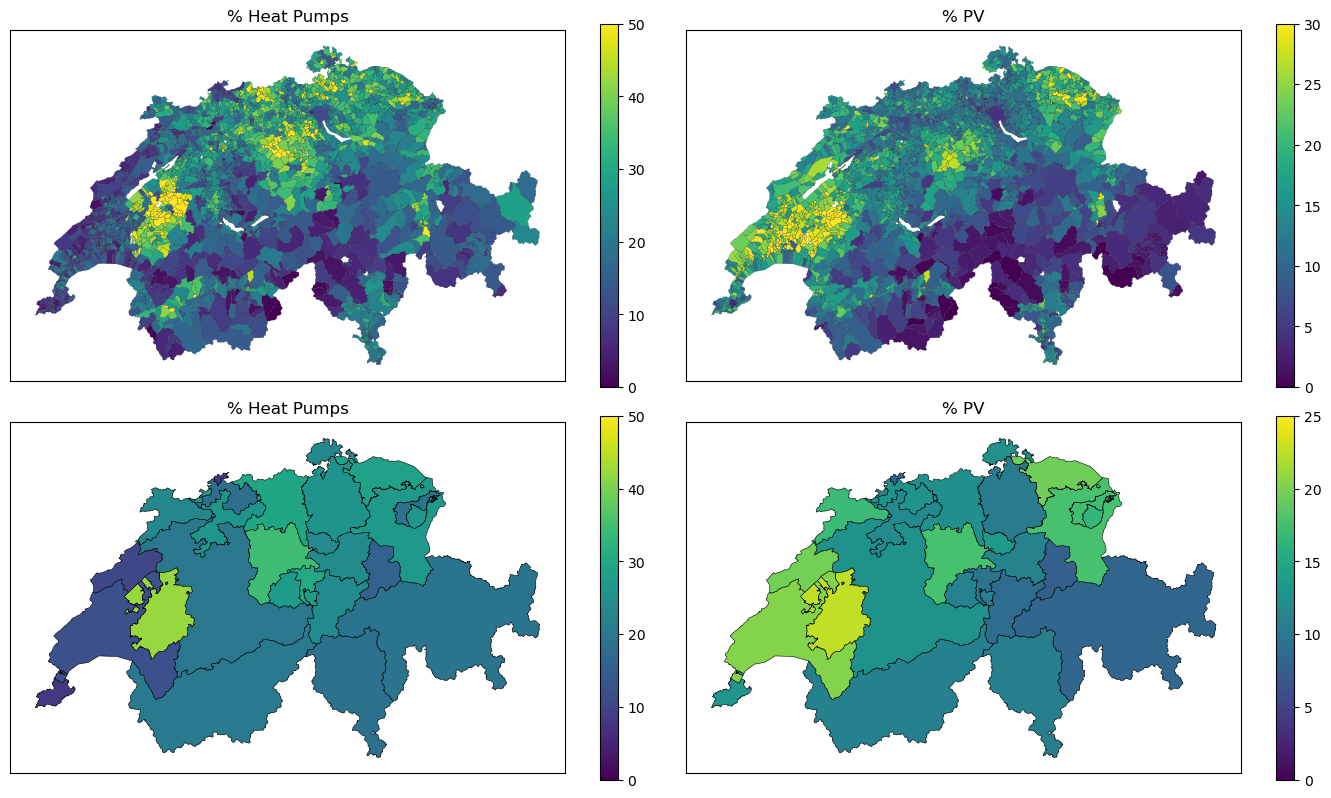

In [26]:
data_m = gdf_2025.pivot_table(index='Municipality', columns='Heating Technology', aggfunc='size', fill_value=0)
data_percentage_m = data_m.div(data_m.sum(axis=1), axis=0) * 100
data_percentage_m = data_percentage_m.reset_index(drop=False)
data_percentage_m = data_percentage_m.merge(municipal_limits, how='left', left_on=['Municipality'], right_on=['NAME'])

data_c = gdf_2025.pivot_table(index='Canton', columns='Heating Technology', aggfunc='size', fill_value=0)
data_percentage_c = data_c.div(data_c.sum(axis=1), axis=0) * 100
data_percentage_c = data_percentage_c.reset_index(drop=False)
data_percentage_c = data_percentage_c.merge(cantonal_limits, how='left', left_on=['Canton'], right_on=['NAME'])

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

data_HP_percentage_m = data_percentage_m[['Municipality', 'HeatPump', 'geometry']]
data_HP_percentage_m = data_HP_percentage_m.reset_index(drop=False)
gdf_HP_m = gpd.GeoDataFrame(data_HP_percentage_m, crs="EPSG:2056", geometry='geometry')
gdf_HP_m.plot(ax=axes[0,0], column='HeatPump', legend=True, linewidth=0.1, vmin=0, vmax=50, edgecolor='black', cmap='viridis').set_title('% Heat Pumps')
axes[0,0].set_xticks([])
axes[0,0].set_yticks([])

data_HP_percentage_c = data_percentage_c[['Canton', 'HeatPump', 'geometry']]
data_HP_percentage_c = data_HP_percentage_c.reset_index(drop=False)
gdf_HP_c = gpd.GeoDataFrame(data_HP_percentage_c, crs="EPSG:2056", geometry='geometry')
gdf_HP_c.plot(ax=axes[1,0], column='HeatPump', legend=True, linewidth=0.4, vmin=0, vmax=50, edgecolor='black', cmap='viridis').set_title('% Heat Pumps')
axes[1,0].set_xticks([])
axes[1,0].set_yticks([])

data_m = gdf_2025.pivot_table(index='Municipality', columns='PV', aggfunc='size', fill_value=0)
data_percentage_m = data_m.div(data_m.sum(axis=1), axis=0) * 100
data_percentage_m = data_percentage_m.reset_index(drop=False)
data_percentage_m = data_percentage_m.merge(municipal_limits, how='left', left_on=['Municipality'], right_on=['NAME'])

data_c = gdf_2025.pivot_table(index='Canton', columns='PV', aggfunc='size', fill_value=0)
data_percentage_c = data_c.div(data_c.sum(axis=1), axis=0) * 100
data_percentage_c = data_percentage_c.reset_index(drop=False)
data_percentage_c = data_percentage_c.merge(cantonal_limits, how='left', left_on=['Canton'], right_on=['NAME'])

data_PV_percentage_m = data_percentage_m[['Municipality', 'PVyes', 'geometry']]
data_PV_percentage_m = data_PV_percentage_m.reset_index(drop=False)
gdf_PV_m = gpd.GeoDataFrame(data_PV_percentage_m, crs="EPSG:2056", geometry='geometry')
gdf_PV_m.plot(ax=axes[0,1], column='PVyes', legend=True, linewidth=0.1, vmin=0, vmax=30, edgecolor='black', cmap='viridis').set_title('% PV')
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])

data_PV_percentage_c = data_percentage_c[['Canton', 'PVyes', 'geometry']]
data_PV_percentage_c = data_PV_percentage_c.reset_index(drop=False)
gdf_PV_c = gpd.GeoDataFrame(data_PV_percentage_c, crs="EPSG:2056", geometry='geometry')
gdf_PV_c.plot(ax=axes[1,1], column='PVyes', legend=True, linewidth=0.4, vmin=0, vmax=25, edgecolor='black', cmap='viridis').set_title('% PV')
axes[1,1].set_xticks([])
axes[1,1].set_yticks([])

plt.tight_layout()
plt.show()

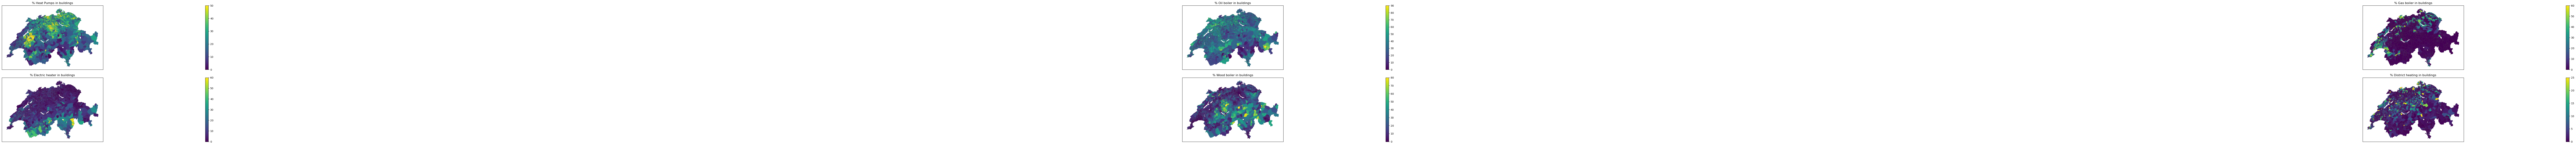

In [27]:
data = gdf_2025.pivot_table(index='Municipality', columns='Heating Technology', aggfunc='size', fill_value=0)
data_percentage = data.div(data.sum(axis=1), axis=0) * 100
data_percentage = data_percentage.reset_index(drop=False)
data_percentage = data_percentage.merge(municipal_limits, how='left', left_on=['Municipality'], right_on=['NAME'])

fig, axes = plt.subplots(2, 3, figsize=(240, 8))

data_HP_percentage = data_percentage[['Municipality', 'HeatPump', 'geometry']]
data_HP_percentage = data_HP_percentage.reset_index(drop=False)
gdf_HP = gpd.GeoDataFrame(data_HP_percentage, crs="EPSG:2056", geometry='geometry')
gdf_HP.plot(ax=axes[0,0], column='HeatPump', legend=True, linewidth=0.1, vmin=0, vmax=50, edgecolor='black', cmap='viridis').set_title('% Heat Pumps in buildings')
axes[0,0].set_xticks([])
axes[0,0].set_yticks([])

data_Oil_percentage = data_percentage[['Municipality', 'Oil', 'geometry']]
data_Oil_percentage = data_Oil_percentage.reset_index(drop=False)
gdf_Oil = gpd.GeoDataFrame(data_Oil_percentage, crs="EPSG:2056", geometry='geometry')
gdf_Oil.plot(ax=axes[0,1], column='Oil', legend=True, linewidth=0.1, vmin=0, vmax=90, edgecolor='black', cmap='viridis').set_title('% Oil boiler in buildings')
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])

data_Gas_percentage = data_percentage[['Municipality', 'Gas', 'geometry']]
data_Gas_percentage = data_Gas_percentage.reset_index(drop=False)
gdf_Gas = gpd.GeoDataFrame(data_Gas_percentage, crs="EPSG:2056", geometry='geometry')
gdf_Gas.plot(ax=axes[0,2], column='Gas', legend=True, linewidth=0.1, vmin=0, vmax=60, edgecolor='black', cmap='viridis').set_title('% Gas boiler in buildings')
axes[0,2].set_xticks([])
axes[0,2].set_yticks([])

data_EH_percentage = data_percentage[['Municipality', 'ElectricHeater', 'geometry']]
data_EH_percentage = data_EH_percentage.reset_index(drop=False)
gdf_EH = gpd.GeoDataFrame(data_EH_percentage, crs="EPSG:2056", geometry='geometry')
gdf_EH.plot(ax=axes[1,0], column='ElectricHeater', legend=True, linewidth=0.1, vmin=0, vmax=60, edgecolor='black', cmap='viridis').set_title('% Electric heater in buildings')
axes[1,0].set_xticks([])
axes[1,0].set_yticks([])

data_Wood_percentage = data_percentage[['Municipality', 'Wood', 'geometry']]
data_Wood_percentage = data_Wood_percentage.reset_index(drop=False)
gdf_Wood = gpd.GeoDataFrame(data_Wood_percentage, crs="EPSG:2056", geometry='geometry')
gdf_Wood.plot(ax=axes[1,1], column='Wood', legend=True, linewidth=0.1, vmin=0, vmax=80, edgecolor='black', cmap='viridis').set_title('% Wood boiler in buildings')
axes[1,1].set_xticks([])
axes[1,1].set_yticks([])

data_DH_percentage = data_percentage[['Municipality', 'DH', 'geometry']]
data_DH_percentage = data_DH_percentage.reset_index(drop=False)
gdf_DH = gpd.GeoDataFrame(data_DH_percentage, crs="EPSG:2056", geometry='geometry')
gdf_DH.plot(ax=axes[1,2], column='DH', legend=True, linewidth=0.1, vmin=0, vmax=25, edgecolor='black', cmap='viridis').set_title('% District heating in buildings')
axes[1,2].set_xticks([])
axes[1,2].set_yticks([])

plt.tight_layout()
plt.show()

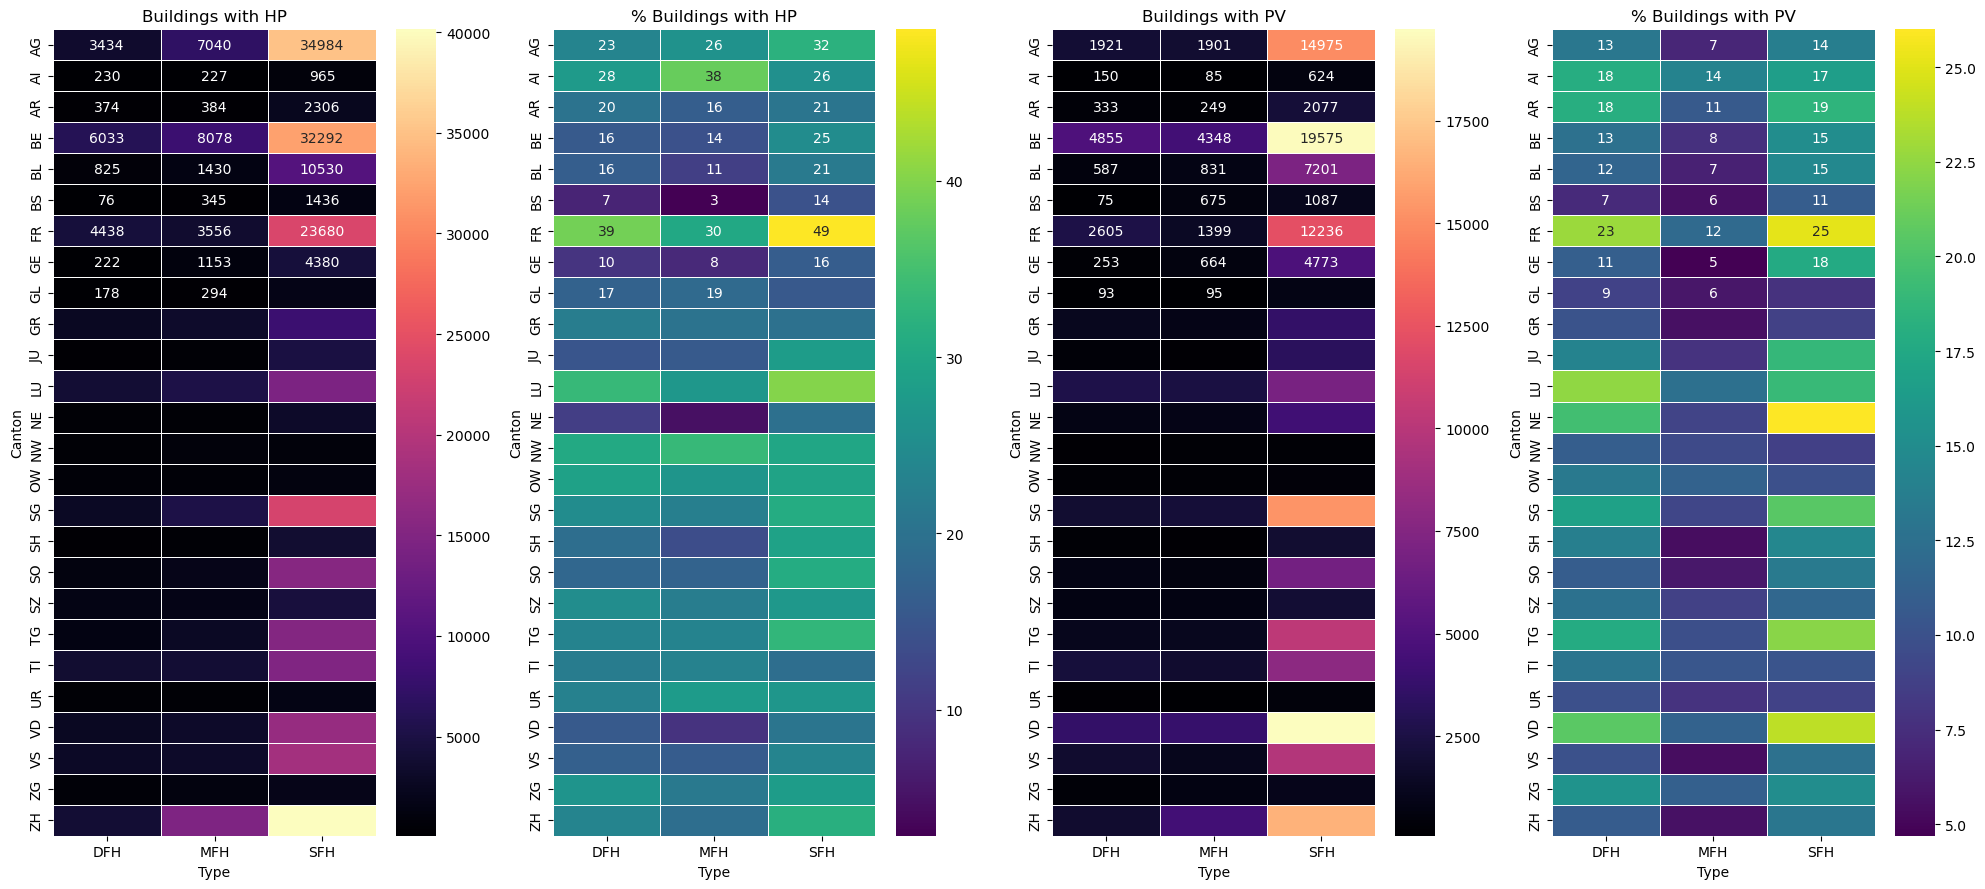

In [28]:
fig, axes = plt.subplots(1, 4, figsize=(20, 9))

gdf_HP = gdf_2025[gdf_2025["Heating Technology"].isin(["HeatPump", 'HPST']) & gdf_2025["Type"].isin(["SFH", 'DFH', 'MFH'])]
data_HP = gdf_HP.pivot_table(index='Canton', columns='Type', aggfunc='size', fill_value=0)
sns.heatmap(data_HP,annot=True, fmt=".0f", cmap='magma', ax=axes[0], cbar=True, linewidth=.5).set_title('Buildings with HP')

data_TOT = gdf_2025[gdf_2025["Type"].isin(["SFH", 'DFH', 'MFH'])].pivot_table(index='Canton', columns='Type', aggfunc='size', fill_value=0)
data_HP_share = data_HP / data_TOT * 100
sns.heatmap(data_HP_share,annot=True, fmt=".0f", cmap='viridis', ax=axes[1], cbar=True, linewidth=.5).set_title('% Buildings with HP')

gdf_PV = gdf_2025[gdf_2025["PV"].isin(["PVyes"]) & gdf_2025["Type"].isin(["SFH", 'DFH', 'MFH'])]
data_PV = gdf_PV.pivot_table(index='Canton', columns='Type', aggfunc='size', fill_value=0)
sns.heatmap(data_PV,annot=True, fmt=".0f", cmap='magma', ax=axes[2], cbar=True, linewidth=.5).set_title('Buildings with PV')

data_PV_share = data_PV / data_TOT * 100
sns.heatmap(data_PV_share,annot=True, fmt=".0f", cmap='viridis', ax=axes[3], cbar=True, linewidth=.5).set_title('% Buildings with PV')

plt.tight_layout()

plt.show()

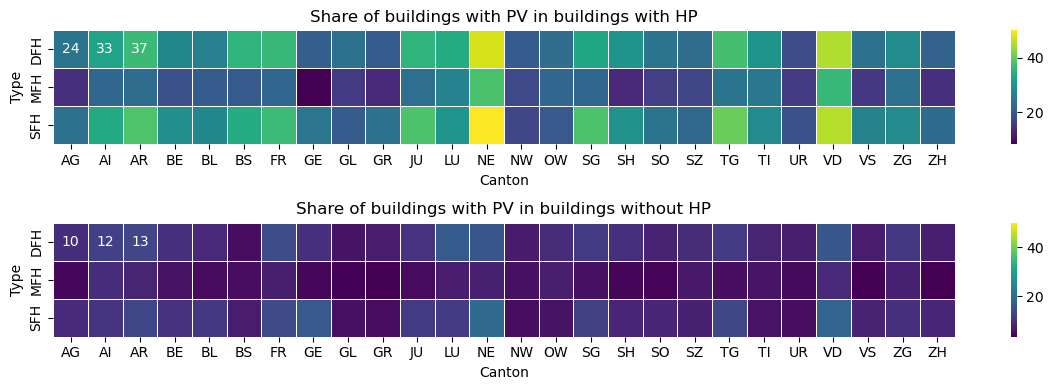

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(12, 4))

gdf_PV_HP = gdf_2025[gdf_2025["PV"].isin(["PVyes"]) & gdf_2025["Type"].isin(["SFH", 'DFH', 'MFH']) & gdf_2025["Heating Technology"].isin(["HeatPump", 'HPST'])]
data_PV_HP = gdf_PV_HP.pivot_table(index='Type', columns='Canton', aggfunc='size', fill_value=0)

data_HP = gdf_HP.pivot_table(index='Type', columns='Canton', aggfunc='size', fill_value=0)

data_PV_share_HP = data_PV_HP / data_HP * 100
sns.heatmap(data_PV_share_HP, annot=True, fmt=".0f", cmap='viridis', ax=axes[0], cbar=True, linewidth=.5, vmax=50)

gdf_PV_no_HP = gdf_2025[gdf_2025["PV"].isin(["PVyes"]) & gdf_2025["Type"].isin(["SFH", 'DFH', 'MFH']) & (~gdf_2025["Heating Technology"].isin(["HeatPump", 'HPST', 'HPOil', 'HPGas']))]
data_PV_no_HP = gdf_PV_no_HP.pivot_table(index='Type', columns='Canton', aggfunc='size', fill_value=0)

gdf_no_HP = gdf_2025[gdf_2025["Type"].isin(["SFH", 'DFH', 'MFH']) & (~gdf_2025["Heating Technology"].isin(["HeatPump", 'HPST']))]
data_no_HP = gdf_no_HP.pivot_table(index='Type', columns='Canton', aggfunc='size', fill_value=0)

data_PV_share_no_HP = data_PV_no_HP / data_no_HP * 100
sns.heatmap(data_PV_share_no_HP, annot=True, fmt=".0f", cmap='viridis', ax=axes[1], cbar=True, linewidth=.5, vmax=50)

axes[0].set_title('Share of buildings with PV in buildings with HP')
axes[1].set_title('Share of buildings with PV in buildings without HP')

plt.tight_layout()

plt.show()

In [30]:
ev_share_file = '/data/Drivers/share_EVs_can.csv'

df_ev_share_raw = pd.read_csv(
    notebook_dir + ev_share_file, 
    sep=";", 
    skiprows=3,
    names=["ID", "Canton_raw", "EV share [%]"]
)

df_ev_share_raw["EV share [%]"] = pd.to_numeric(df_ev_share_raw["EV share [%]"], errors="coerce")

name_to_code = {
    'Zürich': 'ZH', 'Zurigo': 'ZH', 'Zurich': 'ZH',
    'Bern': 'BE', 'Berna': 'BE',
    'Luzern': 'LU', 'Lucerne': 'LU',
    'Uri': 'UR',
    'Schwyz': 'SZ',
    'Obwalden': 'OW',
    'Nidwalden': 'NW',
    'Glarus': 'GL',
    'Zug': 'ZG',
    'Fribourg': 'FR', 'Freiburg': 'FR',
    'Solothurn': 'SO',
    'Basel-Stadt': 'BS',
    'Basel-Landschaft': 'BL',
    'Schaffhausen': 'SH', 'Schaffhouse': 'SH',
    'Appenzell Innerrhoden': 'AI',
    'Appenzell Ausserrhoden': 'AR',
    'St. Gallen': 'SG',
    'Graubünden': 'GR', 'Grigioni': 'GR',
    'Aargau': 'AG',
    'Thurgau': 'TG',
    'Ticino': 'TI', 'Tessin': 'TI',
    'Vaud': 'VD', 'Waadt': 'VD',
    'Valais': 'VS', 'Wallis': 'VS',
    'Neuchâtel': 'NE', 'Neuenburg': 'NE', 'Neuchatel': 'NE',
    'Genève': 'GE', 'Geneva': 'GE', 'Genf': 'GE', 'Geneve': 'GE',
    'Jura': 'JU'
}

df_ev_share_raw["Canton"] = df_ev_share_raw["Canton_raw"].map(name_to_code)

_unknown = sorted(df_ev_share_raw.loc[df_ev_share_raw["Canton"].isna(), "Canton_raw"].unique())
if _unknown:
    print("Cantons not recognized in CSV:", _unknown)

df_ev_share = df_ev_share_raw[["Canton", "EV share [%]"]].dropna(subset=["Canton"]).copy()

gdf_2025_drivers = gdf_2025.copy()

gdf_2025_drivers = gdf_2025_drivers.merge(df_ev_share, on="Canton", how="left")
    
_missing = gdf_2025_drivers.loc[gdf_2025_drivers['EV share [%]'].isna(), 'Canton'].unique()
_missing = [str(c) for c in _missing if pd.notna(c)]

if _missing:
    print('Missing EV share for cantons:', ', '.join(_missing))
else:
    print('EV share unified for all cantons')


EV share unified for all cantons


In [31]:
unemployment_file = '/data/Drivers/unemployment_rate_can.csv'

df_unemployment_raw = pd.read_csv(
    notebook_dir + unemployment_file, 
    sep=";", 
    skiprows=3,
    names=["ID", "Canton_raw","Over 65 Share [%]", "Unemployment Rate [%]"]
)

df_unemployment_raw["Unemployment Rate [%]"] = pd.to_numeric(df_unemployment_raw["Unemployment Rate [%]"], errors="coerce")

df_unemployment_raw["Canton"] = df_unemployment_raw["Canton_raw"].map(name_to_code)

_unknown = sorted(df_unemployment_raw.loc[df_unemployment_raw["Canton"].isna(), "Canton_raw"].unique())
if _unknown:
    print("Cantons not recognized in CSV:", _unknown)

df_unemployment = df_unemployment_raw[["Canton", "Unemployment Rate [%]"]].dropna(subset=["Canton"]).copy()

gdf_2025_drivers = gdf_2025_drivers.merge(df_unemployment, on="Canton", how="left")

_missing = gdf_2025_drivers.loc[gdf_2025_drivers['Unemployment Rate [%]'].isna(), 'Canton'].unique()
_missing = [str(c) for c in _missing if pd.notna(c)]

if _missing:
    print('Missing Unemployment Rate for cantons:', ', '.join(_missing))
else:
    print('Unemployment Rate unified for all cantons')

Unemployment Rate unified for all cantons


In [32]:
home_ownership_file = '/data/Drivers/home_ownership_rate_can.csv'

df_home_ownership_raw = pd.read_csv(
    notebook_dir + home_ownership_file, 
    sep=";", 
    skiprows=3,
    names=["ID", "Canton_raw", "Home Ownership Rate [%]"]
)

df_home_ownership_raw["Home Ownership Rate [%]"] = pd.to_numeric(df_home_ownership_raw["Home Ownership Rate [%]"], errors="coerce")

df_home_ownership_raw["Canton"] = df_home_ownership_raw["Canton_raw"].map(name_to_code)

_unknown = sorted(df_home_ownership_raw.loc[df_home_ownership_raw["Canton"].isna(), "Canton_raw"].unique())
if _unknown:
    print("Cantons not recognized in CSV:", _unknown)

df_home_ownership = df_home_ownership_raw[["Canton", "Home Ownership Rate [%]"]].dropna(subset=["Canton"]).copy()

gdf_2025_drivers = gdf_2025_drivers.merge(df_home_ownership, on="Canton", how="left")

_missing = gdf_2025_drivers.loc[gdf_2025_drivers['Home Ownership Rate [%]'].isna(), 'Canton'].unique()
_missing = [str(c) for c in _missing if pd.notna(c)]

if _missing:
    print('Missing Home Ownership Rate for cantons:', ', '.join(_missing))
else:
    print('Home Ownership Rate unified for all cantons')

Home Ownership Rate unified for all cantons


In [33]:
area_categorization_file = '/data/Drivers/area_categotization_mun.xlsx'

df_area_categotization = pd.read_excel(
    notebook_dir + area_categorization_file,
    sheet_name="Dati",
    skiprows=3,
    header=None,
    names=[
        "Municipality Number", "Municipality", "Canton Number", "Canton_raw",
        "District Number","District_raw","Area Type", "Area Category Detail", "Mun_type"
    ],
    dtype=str,
    engine="openpyxl"
)

df_area_categotization = df_area_categotization[[ "Municipality", "Area Type"]].copy()

gdf_2025_drivers = gdf_2025_drivers.merge(
    df_area_categotization,
    how="left",
    on="Municipality"
)

_missing = gdf_2025_drivers.loc[gdf_2025_drivers["Area Type"].isna(), "Municipality"].unique()
print(f"Municipalities not matched: {len(_missing)}")
print(_missing[:20]) 

c:\Users\andre\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Municipalities not matched: 2
["C'za Cadenazzo/Monteceneri" nan]


In [34]:
second_house_file = '/data/Drivers/secondary_house_rate_mun.gpkg'

gdf_second_house = gpd.read_file(notebook_dir + second_house_file)

df_second_house = (gdf_second_house
               .loc[:, ["Name", "ZWG_3120"]]
               .rename(columns={"Name": "Municipality",
                                "ZWG_3120": "Secondary House Rate [%]"})
              )

gdf_2025_drivers = gdf_2025_drivers.merge(
    df_second_house,
    how="left",
    on="Municipality"
)
_missing = gdf_2025_drivers.loc[gdf_2025_drivers["Secondary House Rate [%]"].isna(), "Municipality"].unique()
print(f"Municipalities not matched: {len(_missing)}")
print(_missing[:20]) 

Municipalities not matched: 6
['Lema' 'Grolley-Ponthaux' "C'za Cadenazzo/Monteceneri" nan
 'Basse-Vendline' 'Laténa']


In [35]:
tertiary_edu_file = '/data/Drivers/tertiary_education_share_district.csv'

df_tertiary_edu = pd.read_csv(
    notebook_dir + tertiary_edu_file,
    sep=";", 
    skiprows=3,
    names=["District ID", "District Name", "Tertiary Education Rate [%]"]
)

df_tertiary_edu = df_tertiary_edu[[ "District Name", "Tertiary Education Rate [%]"]].copy()

df_district_mapping = pd.read_excel(
    notebook_dir + area_categorization_file,
    sheet_name="Dati",
    skiprows=3,
    header=None,
    names=[
        "Municipality Number", "Municipality", "Canton Number", "Canton_raw",
        "District Number","District Name","Area Type", "Area Category Detail", "Mun_type"
    ],
    dtype=str,
    engine="openpyxl"
)

df_district_mapping = df_district_mapping[[ "Municipality", "District Name"]].copy()

df_district_mapping = df_district_mapping.merge(
    df_tertiary_edu,
    how="left",
    on="District Name"
)

gdf_2025_drivers = gdf_2025_drivers.merge(
    df_district_mapping,
    how="left",
    on="Municipality"
)




canton_means = (
    gdf_2025_drivers
    .groupby("Canton")['Tertiary Education Rate [%]']
    .transform("mean")   # media solo all’interno del gruppo Canton
)

# sostituisci solo i NaN con la media cantonale
gdf_2025_drivers['Tertiary Education Rate [%]'] = (
    gdf_2025_drivers['Tertiary Education Rate [%]']
    .fillna(canton_means)
)

_missing = gdf_2025_drivers.loc[gdf_2025_drivers['Tertiary Education Rate [%]'].isna(), 'Municipality'].unique()
print(f"Municipalities not matched: {len(_missing)}")
print(_missing[:20])

c:\Users\andre\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Municipalities not matched: 1
[nan]


In [36]:
people_over65_file = '/data/Drivers/people_over_65_mun.csv'

df_people_over65 = pd.read_csv(
    notebook_dir + people_over65_file, 
    sep=";", 
    skiprows=3,
    names=["ID", "Municipality", "People Over 65 [%]"]
)

df_people_over65["People Over 65 [%]"] = pd.to_numeric(df_people_over65["People Over 65 [%]"], errors="coerce")

df_people_over65 = df_people_over65[[ "Municipality", "People Over 65 [%]"]].copy()

gdf_2025_drivers = gdf_2025_drivers.merge(
    df_people_over65,
    how="left",
    on="Municipality"
)

_missing = gdf_2025_drivers.loc[gdf_2025_drivers["People Over 65 [%]"].isna(), "Municipality"].unique()
print(f"Municipalities not matched: {len(_missing)}")
print(_missing[:20]) 


Municipalities not matched: 5
['Lema' 'Grolley-Ponthaux' "C'za Cadenazzo/Monteceneri" nan 'Laténa']


In [37]:
CO2Act_file = '/data/Drivers/CO2Act_yes_mun.csv'

df_CO2Act = pd.read_csv(
    notebook_dir + CO2Act_file, 
    sep=";", 
    skiprows=3,
    names=["ID", "Municipality", "CO2Act Yes Share [%]"]
)

df_CO2Act["CO2Act Yes Share [%]"] = pd.to_numeric(df_CO2Act["CO2Act Yes Share [%]"], errors="coerce")

df_CO2Act = df_CO2Act[[ "Municipality", "CO2Act Yes Share [%]"]].copy()

gdf_2025_drivers = gdf_2025_drivers.merge(
    df_CO2Act,
    how="left",
    on="Municipality"
)

_missing = gdf_2025_drivers.loc[gdf_2025_drivers["People Over 65 [%]"].isna(), "Municipality"].unique()
print(f"Municipalities not matched: {len(_missing)}")
print(_missing[:20]) 


Municipalities not matched: 5
['Lema' 'Grolley-Ponthaux' "C'za Cadenazzo/Monteceneri" nan 'Laténa']


In [38]:
electricity_prices_file = '/data/Drivers/electricity_prices_mun.csv'

df_electricity_prices_raw = pd.read_csv(
    notebook_dir + electricity_prices_file,
)

df_electricity_prices = df_electricity_prices_raw[[" operatorLabel"," category"," total (cts./kWh)"]]

df_electricity_prices = df_electricity_prices.rename(columns={
    " operatorLabel":"Operator",
    " category":"Category",
    " total (cts./kWh)":"Electricity Price (cts./kWh)"
})

df_electricity_prices_H2= df_electricity_prices.drop(df_electricity_prices[df_electricity_prices["Category"] != "H2"].index)
df_electricity_prices_H2=df_electricity_prices_H2[["Operator","Electricity Price (cts./kWh)"]]

df_electricity_prices_H2["Electricity Price (cts./kWh)"] = pd.to_numeric(df_electricity_prices_H2["Electricity Price (cts./kWh)"], errors="coerce")

df_electricity_prices_H2_mean = (
    df_electricity_prices_H2
    .groupby("Operator", as_index=False)["Electricity Price (cts./kWh)"]
    .mean()
)

electricity_providers_file = '/data/Drivers/municipality_providers.csv'
df_electricity_providers_raw = pd.read_csv(
    notebook_dir + electricity_providers_file,
)

df_electricity_providers = df_electricity_providers_raw[["operator","municipalityName"]]
df_electricity_providers = df_electricity_providers.rename(columns={
    "operator":"Operator",
    "municipalityName":"Municipality"
})
df_electricity_providers = df_electricity_providers.drop_duplicates(subset="Municipality", keep="first")

gdf_2025_drivers = gdf_2025_drivers.merge(
    df_electricity_providers,
    how="left",
    on="Municipality",
)
gdf_2025_drivers = gdf_2025_drivers.merge(
    df_electricity_prices_H2_mean,
    how="left",
    on="Operator",
)

_missing = gdf_2025_drivers.loc[gdf_2025_drivers["Electricity Price (cts./kWh)"].isna(), "Municipality"].unique()
print(f"Municipalities not matched: {len(_missing)}")
print(_missing[:20]) 

Municipalities not matched: 17
['Augst' 'Reigoldswil' 'Rudolfstetten-Friedlisberg' 'Beinwil (Freiamt)'
 'Lema' 'Bourg-Saint-Pierre' 'Liddes' 'Orsières' 'Albula/Alvra'
 'Deisswil bei Münchenbuchsee' 'Niederried bei Interlaken'
 'Vuisternens-devant-Romont' 'Grolley-Ponthaux'
 "C'za Cadenazzo/Monteceneri" nan 'Hergiswil bei Willisau' 'Laténa']


In [39]:
incentives_file = '/data/Drivers/incentives_can.xlsx'

df_incentives = pd.read_excel(
    notebook_dir + incentives_file,
    sheet_name="Applicazione MoPEC",
    skiprows=1,
    header=None,
    names=[
        "Canton", "Art 1.29", "Art 1.26"
    ],
    dtype=str,
    engine="openpyxl"
)

df_incentives['Art 1.29 (Heating Sys)'] = df_incentives['Art 1.29'].isin(['Yes']).astype(int)
df_incentives['Art 1.26 (PV)'] = df_incentives['Art 1.26'].isin(['Yes']).astype(int)
df_incentives = df_incentives.drop(columns=['Art 1.29', 'Art 1.26'])


gdf_2025_drivers = gdf_2025_drivers.merge(
    df_incentives,
    how="left",
    on="Canton"
)

pd.set_option('display.max_columns', None)

In [ ]:
gdf_peer = gdf_2025_drivers.copy()

gdf_peer['pv_year'] = pd.to_numeric(gdf_peer['Initial operation PV'], errors='coerce').astype('Int64')
last_year = int(pd.to_numeric(gdf_peer['Initial operation PV'], errors='coerce').dropna().max())

n_buildings = (
    gdf_peer.groupby('Municipality')
            .size().rename('n_buildings')
            .reset_index()
)

counts = (
    gdf_peer.dropna(subset=['pv_year'])
            .groupby(['Municipality','pv_year'])
            .size().rename('n')
            .reset_index()
)

def prev3_to_year(g, end_year):
    s = g.set_index('pv_year')['n']
    start = int(s.index.min())
    yrs = pd.RangeIndex(start, int(end_year) + 1)
    s = s.reindex(yrs, fill_value=0)
    out = (
        s.rolling(3, min_periods=1).sum()
         .shift(1, fill_value=0)
         .rename('pv_prev3')
         .reset_index().rename(columns={'index':'pv_year'})
    )
    out['Municipality'] = g['Municipality'].iloc[0]
    return out

if not counts.empty:
    prev3_df = (
        counts.groupby('Municipality', group_keys=False)
              .apply(lambda g: prev3_to_year(g, last_year))
              .astype({'pv_year':'Int64'})
              .reset_index(drop=True)
    )
else:
    prev3_df = pd.DataFrame(columns=['Municipality','pv_year','pv_prev3'])

gdf_peer = gdf_peer.merge(prev3_df, on=['Municipality','pv_year'], how='left')
gdf_peer = gdf_peer.merge(n_buildings, on='Municipality', how='left')

peer_install = (gdf_peer['pv_prev3'] / gdf_peer['n_buildings'])

peer_obs = (
    prev3_df[prev3_df['pv_year'] == last_year][['Municipality','pv_prev3']]
    .merge(n_buildings, on='Municipality', how='right')
)
peer_obs['pv_prev3'] = peer_obs['pv_prev3'].fillna(0)
peer_obs['peer_effect_obs'] = peer_obs['pv_prev3'] / peer_obs['n_buildings']
peer_obs = peer_obs[['Municipality','peer_effect_obs']]

gdf_peer['peer_effect_PV_prev3'] = np.where(
    gdf_peer['pv_year'].notna(),
    peer_install,
    np.nan
)
gdf_peer = gdf_peer.merge(peer_obs, on='Municipality', how='left')
gdf_peer['peer_effect_PV_prev3'] = gdf_peer['peer_effect_PV_prev3'].fillna(gdf_peer['peer_effect_obs'])
gdf_peer.drop(columns=['peer_effect_obs'], inplace=True)

gdf_2025_drivers['peer_effect_PV_prev3'] = gdf_peer['peer_effect_PV_prev3'].values

In [156]:

mapping_age = {
    "> 2010": 7.5,
    "2001-2010": 20,
    "1991-2000": 30,
    "1981-1990": 40,
    "1971-1980": 50,
    "1961-1970": 60,
    "1946-1960": 72.5,
    "1921-1945": 92.5,
    "< 1920": 115
}


gdf_2025_drivers['Building Age'] = 2025 - gdf_2025_drivers['Construction Year']

gdf_2025_drivers['Building Age'] = gdf_2025_drivers['Building Age'].fillna(
    gdf_2025_drivers['Construction Period']
)

gdf_2025_drivers['Building Age'] = gdf_2025_drivers['Building Age'].replace(mapping_age)

gdf_2025_drivers["Heating System Age"] = 2025 - gdf_2025_drivers["Initial operation Heating"]

gdf_2025_drivers['DH Dummy'] = gdf_2025_drivers['Heating Technology'].isin(['DH']).astype(int)
gdf_2025_drivers['HP Dummy'] = gdf_2025_drivers['Heating Technology'].isin(['HeatPump', 'HPST']).astype(int)
gdf_2025_drivers['PV Dummy'] = gdf_2025_drivers['PV'].isin(['PVyes']).astype(int)
'''gdf_2025_drivers['Age 1'] = gdf_2025_drivers['Construction Period'].isin(['< 1920']).astype(int)
gdf_2025_drivers['Age 2'] = gdf_2025_drivers['Construction Period'].isin(['1921-1945']).astype(int)
gdf_2025_drivers['Age 3'] = gdf_2025_drivers['Construction Period'].isin(['1946-1960']).astype(int)
gdf_2025_drivers['Age 4'] = gdf_2025_drivers['Construction Period'].isin(['1961-1970']).astype(int)
gdf_2025_drivers['Age 5'] = gdf_2025_drivers['Construction Period'].isin(['1971-1980']).astype(int)
gdf_2025_drivers['Age 6'] = gdf_2025_drivers['Construction Period'].isin(['1981-1990']).astype(int)
gdf_2025_drivers['Age 7'] = gdf_2025_drivers['Construction Period'].isin(['1991-2000']).astype(int)
gdf_2025_drivers['Age 8'] = gdf_2025_drivers['Construction Period'].isin(['2001-2010']).astype(int)'''
gdf_2025_drivers['Urban'] = gdf_2025_drivers['Area Type'].isin(['1']).astype(int)
gdf_2025_drivers['Rural'] = gdf_2025_drivers['Area Type'].isin(['3']).astype(int)
gdf_2025_drivers['SFH'] = gdf_2025_drivers['Type'].isin(['SFH']).astype(int)
gdf_2025_drivers['MFH'] = gdf_2025_drivers['Type'].isin(['MFH']).astype(int)


In [ ]:
df_regression_PV = gdf_2025_drivers[['Building Age','Tertiary Education Rate [%]','Unemployment Rate [%]',
                                  'Home Ownership Rate [%]','EV share [%]', 'Electricity Price (cts./kWh)',
                                  'Specific Roof Potential [kWh/m2y]','SFH', 'MFH', 'peer_effect_PV_prev3',
                                  'HP Dummy','Urban', 'Rural','Secondary House Rate [%]','CO2Act Yes Share [%]','PV Dummy']].copy()


nan_rows_PV = df_regression_PV.isna().any(axis=1).sum()
total_rows_PV = len(df_regression_PV)
print(f"Total rows: {total_rows_PV}")
print(f"NaN rows: {nan_rows_PV}")
print(f"Percentage NaN rows: {nan_rows_PV / total_rows_PV * 100:.2f}%")

df_regression_HP = gdf_2025_drivers[['Building Age','Heating System Age', 'Tertiary Education Rate [%]','Unemployment Rate [%]',
                                  'Home Ownership Rate [%]','EV share [%]', 'Electricity Price (cts./kWh)','SFH', 'MFH','HP Dummy','Urban', 'Rural',
                                  'Secondary House Rate [%]','CO2Act Yes Share [%]','PV Dummy', 'DH Dummy']].copy()

nan_rows_HP = df_regression_HP.isna().any(axis=1).sum()
total_rows_HP = len(df_regression_HP)
print(f"Total rows: {total_rows_HP}")
print(f"NaN rows: {nan_rows_HP}")
print(f"Percentage NaN rows: {nan_rows_HP / total_rows_HP * 100:.2f}%")


Total rows: 1718335
NaN rows: 42836
Percentage NaN rows: 2.49%
Total rows: 1718335
NaN rows: 42836
Percentage NaN rows: 2.49%


In [159]:
gdf_2025_drivers.head()
print(gdf_2025_drivers.columns)
print(df_regression_PV.columns)

Index(['EGID', 'Roof area [m2]', 'Total potential [kWh/y]',
       'Summer potential [kWh/y]', 'Winter potential [kWh/y]', 'geometry',
       'Canton', 'Municipality', 'Construction Year', 'xtf_id', 'Type',
       'Construction Period', 'Heating Technology', 'PV', 'PV power',
       'Initial operation Heating', 'Initial operation PV',
       'Specific Roof Potential [kWh/m2y]', 'EV share [%]',
       'Unemployment Rate [%]', 'Home Ownership Rate [%]', 'Area Type',
       'Secondary House Rate [%]', 'District Name',
       'Tertiary Education Rate [%]', 'People Over 65 [%]',
       'CO2Act Yes Share [%]', 'Operator', 'Electricity Price (cts./kWh)',
       'Art 1.29 (Heating Sys)', 'Art 1.26 (PV)', 'peer_effect_PV_prev3',
       'Building Age', 'Heating System Age', 'DH Dummy', 'HP Dummy',
       'PV Dummy', 'Urban', 'Rural', 'SFH', 'MFH'],
      dtype='object')
Index(['Building Age', 'Heating System Age', 'Tertiary Education Rate [%]',
       'Unemployment Rate [%]', 'Home Ownership Rat

In [160]:
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss
from statsmodels.api import Logit, add_constant
from scipy.stats import chi2
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

if 'PV Dummy' not in df_regression_PV.columns:
    raise ValueError("Column 'PV Dummy' not found. Make sure it has been created as in your previous code.")
y = df_regression_PV['PV Dummy'].astype(int)

base_predictors = [
    'Tertiary Education Rate [%]','Unemployment Rate [%]', 'peer_effect_PV_prev3',
    'Home Ownership Rate [%]','EV share [%]', 'Electricity Price (cts./kWh)','Building Age','Specific Roof Potential [kWh/m2y]','SFH', 'MFH',
    'HP Dummy','Urban', 'Rural','Secondary House Rate [%]','CO2Act Yes Share [%]'
]

predictors = [c for c in base_predictors if c in df_regression_PV.columns]
if not predictors:
    raise ValueError("No predictors available among those expected. Check merges and column names.")

data = df_regression_PV[predictors + ['PV Dummy']].dropna().copy()
y = data['PV Dummy'].astype(int)

X_raw = data.drop(columns=['PV Dummy'])

X = X_raw.copy()

no_scale = [
            'SFH', 'MFH','HP Dummy','Urban', 'Rural'
]

no_scale = [c for c in no_scale if c in X.columns]

to_scale = [c for c in X.columns if c not in no_scale]

scaler = StandardScaler()
X_std = X.copy()
if to_scale:
    X_std[to_scale] = scaler.fit_transform(X[to_scale])

def fit_logit(Xmat, yvec, maxiter=500):
    """Fit Logit with intercept; handles empty X (constant only)."""
    Xc = add_constant(Xmat, has_constant='add')
    model = Logit(yvec, Xc).fit(disp=False, maxiter=maxiter)
    return model

def lrt(model_restricted, model_full, df_diff=1):
    """Likelihood Ratio Test: 2*(LL_full - LL_restricted) ~ chi2(df_diff)."""
    D = 2.0 * (model_full.llf - model_restricted.llf)
    p = 1.0 - chi2.cdf(D, df_diff)
    return D, p

alpha_add = 0.05
remaining = list(X_std.columns)
selected = []

current_model = fit_logit(np.zeros((len(y), 0)), y)

improved = True
while improved and remaining:
    best_p = 1.0
    best_var = None
    best_model = None
    for var in remaining:
        trial_vars = selected + [var]
        try:
            m_full = fit_logit(X_std[trial_vars], y)
            _, p = lrt(current_model, m_full, df_diff=1)
        except Exception:
            continue
        if p < best_p:
            best_p = p
            best_var = var
            best_model = m_full
    if best_var is not None and best_p < alpha_add:
        selected.append(best_var)
        remaining.remove(best_var)
        current_model = best_model
    else:
        improved = False

print(f"[Stepwise] Variables selected ({len(selected)}): {selected}")

if not selected:
    raise RuntimeError("No variable was selected with the set LRT threshold. Try increasing α_add (e.g. 0.05).")

X_tr, X_te, y_tr, y_te = train_test_split(
    X_std[selected], y, test_size=0.20, stratify=y, random_state=0
)

model_final = fit_logit(X_tr, y_tr)

p_te = model_final.predict(add_constant(X_te, has_constant='add')).clip(1e-9, 1 - 1e-9)

auc = roc_auc_score(y_te, p_te)
ll = log_loss(y_te, p_te)
brier = brier_score_loss(y_te, p_te)

print("\n=== PERFORMANCE (Test holdout) ===")
print(f"AUC:       {auc:.3f}")
print(f"LogLoss:   {ll:.3f}")
print(f"Brier:     {brier:.3f}")

print("\n=== MODEL (Train) ===")
print(f"LogLik: {model_final.llf:.1f} | AIC: {model_final.aic:.1f} | BIC: {model_final.bic:.1f}")

pd.set_option('display.max_rows', None) 

coef = pd.Series(model_final.params, index=['Intercept'] + selected)
print("\n=== Coefficients (standardized) ===")
print(coef.sort_values())

Xc_full = add_constant(X_std[selected], has_constant='add')
data['PV_prob_hat'] = fit_logit(X_std[selected], y).predict(Xc_full).clip(1e-6, 1-1e-6)

out = df_regression_PV.loc[data.index].copy()
out['PV_prob_hat'] = data['PV_prob_hat'].values

cols_export = [c for c in ['EGID', 'Municipality', 'Canton'] if c in out.columns] + ['PV_prob_hat']
pv_scores = out[cols_export].copy()


[Stepwise] Variables selected (14): ['Tertiary Education Rate [%]', 'Unemployment Rate [%]', 'peer_effect_PV_prev3', 'Home Ownership Rate [%]', 'Building Age', 'Specific Roof Potential [kWh/m2y]', 'Electricity Price (cts./kWh)', 'SFH', 'MFH', 'HP Dummy', 'EV share [%]', 'Rural', 'Urban', 'Secondary House Rate [%]']

=== PERFORMANCE (Test holdout) ===
AUC:       0.988
LogLoss:   0.106
Brier:     0.019

=== MODEL (Train) ===
LogLik: -157019.8 | AIC: 314069.6 | BIC: 314251.4

=== Coefficients (standardized) ===
MFH                                 -0.529425
SFH                                 -0.222194
Building Age                        -0.143779
Unemployment Rate [%]               -0.125417
EV share [%]                        -0.059564
Home Ownership Rate [%]             -0.003555
Secondary House Rate [%]             0.015569
Electricity Price (cts./kWh)         0.052998
Tertiary Education Rate [%]          0.096461
Urban                                0.100557
Rural                     

In [161]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

if 'HP Dummy' not in df_regression_HP.columns:
    raise ValueError("Column 'HP Dummy' not found. Make sure it exists in df_regression_HP.")
y = df_regression_HP['HP Dummy'].astype(int)

base_predictors = ['Tertiary Education Rate [%]','Unemployment Rate [%]',
                   'Home Ownership Rate [%]','EV share [%]', 'Electricity Price (cts./kWh)','Building Age','SFH', 'MFH','Urban', 'Rural',
                   'Secondary House Rate [%]','CO2Act Yes Share [%]','PV Dummy', 'DH Dummy']


predictors = [c for c in base_predictors if c in df_regression_HP.columns]
if not predictors:
    raise ValueError("No predictors available among those expected. Check merges and column names.")

data = df_regression_HP[predictors + ['HP Dummy']].dropna().copy()
y = data['HP Dummy'].astype(int)
X_raw = data.drop(columns=['HP Dummy'])

X = X_raw.copy()

no_scale = ['SFH', 'MFH',
            'Urban', 'Rural','PV Dummy', 'DH Dummy']

no_scale = [c for c in no_scale if c in X.columns]

to_scale = [c for c in X.columns if c not in no_scale]

scaler = StandardScaler()
X_std = X.copy()
if to_scale:
    X_std[to_scale] = scaler.fit_transform(X[to_scale])

def fit_logit(Xmat, yvec, maxiter=500):
    """Fit Logit with intercept; handles empty X (constant only)."""
    Xc = add_constant(Xmat, has_constant='add')
    model = Logit(yvec, Xc).fit(disp=False, maxiter=maxiter)
    return model

def lrt(model_restricted, model_full, df_diff=1):
    """Likelihood Ratio Test: 2*(LL_full - LL_restricted) ~ chi2(df_diff)."""
    D = 2.0 * (model_full.llf - model_restricted.llf)
    p = 1.0 - chi2.cdf(D, df_diff)
    return D, p

alpha_add = 0.05
remaining = list(X_std.columns)
selected = []

current_model = fit_logit(np.zeros((len(y), 0)), y)

improved = True
while improved and remaining:
    best_p = 1.0
    best_var = None
    best_model = None
    for var in remaining:
        trial_vars = selected + [var]
        try:
            m_full = fit_logit(X_std[trial_vars], y)
            _, p = lrt(current_model, m_full, df_diff=1)
        except Exception:
            continue
        if p < best_p:
            best_p = p
            best_var = var
            best_model = m_full
    if best_var is not None and best_p < alpha_add:
        selected.append(best_var)
        remaining.remove(best_var)
        current_model = best_model
    else:
        improved = False

print(f"[Stepwise] Variables selected ({len(selected)}): {selected}")

if not selected:
    raise RuntimeError("No variable was selected with the set LRT threshold. Try increasing α_add (e.g. 0.5).")

X_tr, X_te, y_tr, y_te = train_test_split(
    X_std[selected], y, test_size=0.20, stratify=y, random_state=0
)

model_final = fit_logit(X_tr, y_tr)

p_te = model_final.predict(add_constant(X_te, has_constant='add')).clip(1e-9, 1 - 1e-9)

auc = roc_auc_score(y_te, p_te)
ll = log_loss(y_te, p_te)
brier = brier_score_loss(y_te, p_te)

print("\n=== PERFORMANCE (Test holdout) ===")
print(f"AUC:       {auc:.3f}")
print(f"LogLoss:   {ll:.3f}")
print(f"Brier:     {brier:.3f}")

print("\n=== MODEL (Train) ===")
print(f"LogLik: {model_final.llf:.1f} | AIC: {model_final.aic:.1f} | BIC: {model_final.bic:.1f}")


pd.set_option('display.max_rows', None)

coef = pd.Series(model_final.params, index=['Intercept'] + selected)
print("\n=== Coefficients (standardized) ===")
print(coef.sort_values())

Xc_full = add_constant(X_std[selected], has_constant='add')
data['HP_prob_hat'] = fit_logit(X_std[selected], y).predict(Xc_full).clip(1e-6, 1 - 1e-6)

out = df_regression_HP.loc[data.index].copy()
out['HP_prob_hat'] = data['HP_prob_hat'].values

cols_export = [c for c in ['EGID', 'Municipality', 'Canton'] if c in out.columns] + ['HP_prob_hat']
hp_scores = out[cols_export].copy()

# hp_scores.to_csv("hp_adoption_probabilities.csv", index=False)

KeyboardInterrupt: 